In [1]:
import os
import torch
from chemprop import models
from chemprop.data import build_dataloader
import numpy as np
import pandas as pd
from lightning import pytorch as pl
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from src.utils import load_known_rxns
from src.featurizer import RCVNReactionMolGraphFeaturizer, MultiHotAtomFeaturizer, MultiHotBondFeaturizer
from src.data import RxnRCDatapoint, RxnRCDataset

In [2]:
ds_name = 'sprhea'
toc = 'sp_folded_pt'
gs_name = 'two_channel_mean_agg_binaryffn_pred_neg_1'
seed = 1234
neg_multiple = 1
known_rxns = load_known_rxns(f"./data/{ds_name}/known_rxns_{toc}.json")
n_epochs = 25

In [3]:
model_pref = f"/projects/p30041/spn1560/hiec/artifacts/model_evals/gnn/{gs_name}_{ds_name}_{toc}_{n_epochs}_epochs_seed_1234_split_"
n_splits = 5
featurizer = RCVNReactionMolGraphFeaturizer(
    atom_featurizer=MultiHotAtomFeaturizer.no_stereo(),
    bond_featurizer=MultiHotBondFeaturizer()
)

for i in range(n_splits):
    model_dir = model_pref + f"{i+1}_of_{n_splits}/version_0/checkpoints"
    fn = os.listdir(model_dir)[0]
    model_path = model_dir + f"/{fn}"
    mpnn = models.MPNN.load_from_file(model_path, map_location=torch.device('cpu'))
    test_data_path = f"/scratch/spn1560/{ds_name}_{toc}_{n_splits}_splits_{seed}_seed_{neg_multiple}_neg_multiple_{i}_split_idx_test.npy"
    test_data = np.load(test_data_path)

    datapoints_test = []
    for row in test_data[:100]:
        rxn = known_rxns[row['feature']]
        y = np.array([row['y']])
        datapoints_test.append(RxnRCDatapoint.from_smi(rxn, y=y, x_d=row['sample_embed']))

    dataset_test = RxnRCDataset(datapoints_test, featurizer=featurizer)

    data_loader_test = build_dataloader(dataset_test, shuffle=False)

    # break
    # Test
    with torch.inference_mode():
        trainer = pl.Trainer(
            logger=None,
            enable_progress_bar=True,
            accelerator="cpu",
            devices=1
        )
        test_preds = trainer.predict(mpnn, data_loader_test)

    break

/home/spn1560/.conda/envs/hiec/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/spn1560/.conda/envs/hiec/lib/python3.11/site-p ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/spn1560/.conda/envs/hiec/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to

Predicting: |          | 0/? [00:00<?, ?it/s]

In [5]:
logits = np.vstack(test_preds)
y_pred = (logits > 0.5).astype(np.int64).reshape(-1,)
y_true = test_data['y'][:100]

scorers = {
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred),
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred),
    'accuracy': accuracy_score
}

scores = {}

for k, scorer in scorers.items():
    scores[k] = scorer(y_true, y_pred)

print(scores)

{'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'accuracy': 0.0}


/home/spn1560/.conda/envs/hiec/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# Loss curves

path_lc = f"/projects/p30041/spn1560/hiec/artifacts/model_evals/gnn/two_channel_mean_agg_binaryffn_pred_neg_1_sprhea_sp_folded_pt_25_epochs_seed_1234_split_2_of_5/version_0/metrics.csv"
lc = pd.read_csv(path_lc, sep=',')
lc.head()

,epoch,step,train_loss
0,0,49,0.062064
1,0,99,0.026067
2,0,149,0.011338
3,0,199,0.002683
4,0,249,0.000590


<Axes: xlabel='epoch'>

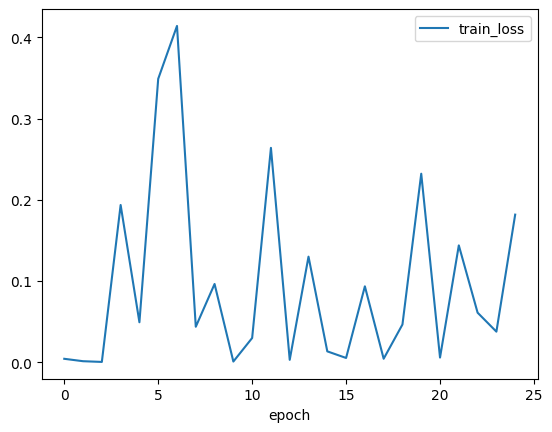

In [40]:

ep_ave_lc = lc.groupby('epoch').agg('mean').reset_index()
ep_ave_lc.plot(x='epoch', y='train_loss')

In [8]:
# Count train data size

train_path = "/scratch/spn1560/sprhea_sp_folded_pt_5_splits_1234_seed_1_neg_multiple_0_split_idx_train.npy"
train_data = np.load(train_path)
train_data[:3]

array([([-1.36408299e-01,  1.70078695e-01, -4.10419963e-02, ...,  5.00185154e-02, -7.75842145e-02,  9.05845314e-02], 'R84126efbb9122177f50f81fcff58422c31a5cf7ef7254420a381ce0f8ade1ec8', 1),
       ([-5.85509576e-02,  2.77130008e-01, -5.79889677e-02, ...,  5.12429625e-02, -1.62841991e-01, -1.20348610e-01], 'R84126efbb9122177f50f81fcff58422c31a5cf7ef7254420a381ce0f8ade1ec8', 1),
       ([ 8.31682459e-02,  1.53674260e-01, -2.82920245e-02, ...,  3.63271832e-02, -1.04916975e-01,  1.04078010e-01], 'R84126efbb9122177f50f81fcff58422c31a5cf7ef7254420a381ce0f8ade1ec8', 1)],
      dtype=[('sample_embed', '<f4', (1280,)), ('feature', '<U100'), ('y', '<i8')])

In [10]:
len(train_data)

87586

In [38]:
labels = train_data['y']
labels[labels == 1].shape, labels[labels == 0].shape

((43793,), (43793,))

In [60]:
import src
df = pd.read_csv('./data/sprhea/sp_folded_pt_test.csv', sep='\t')
krs = src.utils.load_json('./data/sprhea/known_rxns_sp_folded_pt_test.json')
df.head()

,Entry,Label,Sequence
0,Q0WSX8,R84126efbb9122177f50f81fcff58422c31a5cf7ef7254...,MDEQVQEPLSDQVFINFRGDELREIFVNHLELQLRNAGINVFIDTK...
1,Q01638,R84126efbb9122177f50f81fcff58422c31a5cf7ef7254...,MGFWILAILTILMYSTAAKFSKQSWGLENEALIVRCPRQGKPSYTV...
2,O05442,R84126efbb9122177f50f81fcff58422c31a5cf7ef7254...,MAPLAVDPAALDSAGGAVVAAGAGLGAVISSLTAALAGCAGMAGDD...
3,Q2KHU5,Rc9681a11a594bad8642cf49339e1b320b7f96c180e55d...,MFLQSRVSRLLAQLRAAGQLLGAPRPWPGPSPGATRTRSSACGPPA...
4,Q61098,R84126efbb9122177f50f81fcff58422c31a5cf7ef7254...,MHHEELILTLCILIVKSASKSCIHRSQIHVVEGEPFYLKPCGISAP...


In [61]:
to_save = {}
for i, row in df.iterrows():
    for rid in row['Label'].split(';'):
        to_save[rid] = krs[rid]

In [62]:
src.utils.save_json(to_save, "./data/sprhea/known_rxns_sp_folded_pt_test.json")

In [4]:
import yaml

# Existing YAML file path
file_path = '/projects/p30041/spn1560/hiec/artifacts/model_evals/gnn/two_channel_mean_agg_binaryffn_pred_neg_1_shuffle_batches_sprhea_sp_folded_pt_20p_25_epochs_seed_1234_split_1_of_2/version_0/hparams.yaml'

# Data to append (could be a dictionary, list, etc.)
data_to_append = {
    'new_key': 'new_value',
    'another_key': ['a', 'b', 'c']
}

# Load existing YAML data
with open(file_path, 'r') as file:
    existing_data = yaml.safe_load(file)

# Append new data to existing data
existing_data.update(data_to_append)

# Write combined data back to YAML file
with open(file_path, 'w') as file:
    yaml.dump(existing_data, file)

print(f'Data successfully appended to {file_path}')


Data successfully appended to /projects/p30041/spn1560/hiec/artifacts/model_evals/gnn/two_channel_mean_agg_binaryffn_pred_neg_1_shuffle_batches_sprhea_sp_folded_pt_20p_25_epochs_seed_1234_split_1_of_2/version_0/hparams.yaml


In [2]:
existing_data

{'batch_norm': True,
 'metrics': None,
 'warmup_epochs': 2,
 'init_lr': 0.0001,
 'max_lr': 0.001,
 'final_lr': 0.0001,
 'X_d_transform': None}

Data successfully appended to /projects/p30041/spn1560/hiec/artifacts/model_evals/gnn/two_channel_mean_agg_binaryffn_pred_neg_1_shuffle_batches_sprhea_sp_folded_pt_20p_25_epochs_seed_1234_split_1_of_2/version_0/hparams.yaml
